Shape: (7500, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   7500 non-null   int64  
 1   Age                  7500 non-null   int64  
 2   Gender               7500 non-null   object 
 3   Height_cm            7500 non-null   float64
 4   Weight_kg            7500 non-null   float64
 5   BMI                  7500 non-null   float64
 6   Smoker               7500 non-null   object 
 7   Exercise_Freq        5621 non-null   object 
 8   Diet_Quality         7500 non-null   object 
 9   Alcohol_Consumption  5608 non-null   object 
 10  Chronic_Disease      7500 non-null   object 
 11  Stress_Level         7500 non-null   int64  
 12  Sleep_Hours          7500 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 761.8+ KB


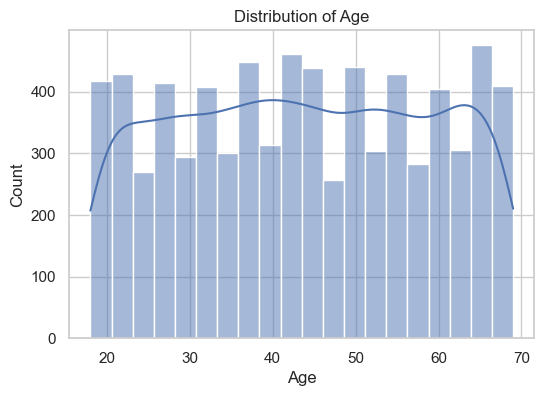

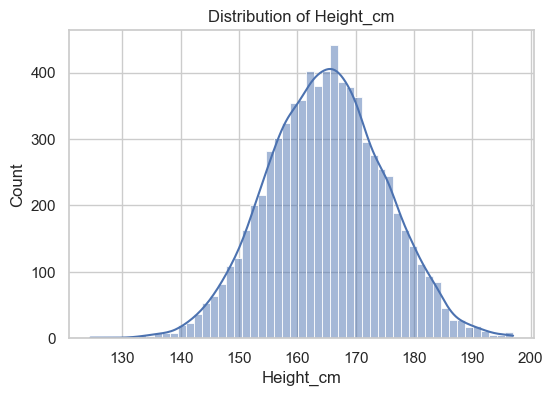

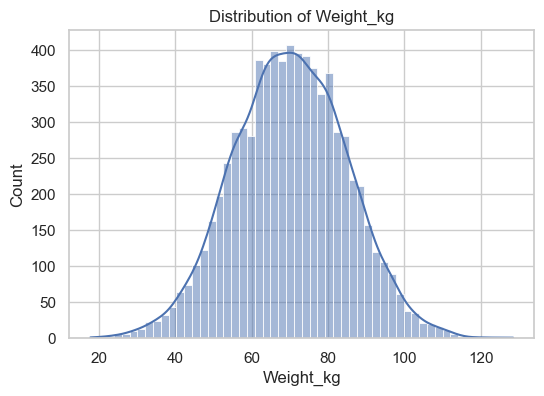

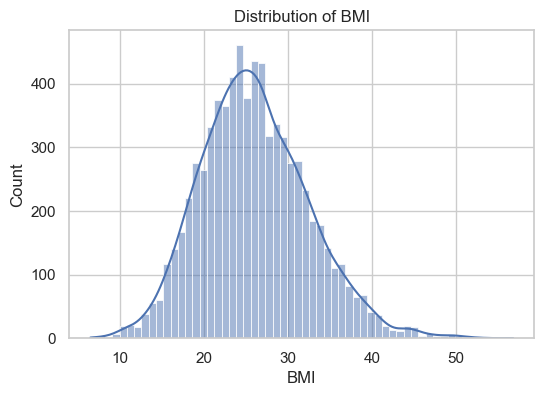

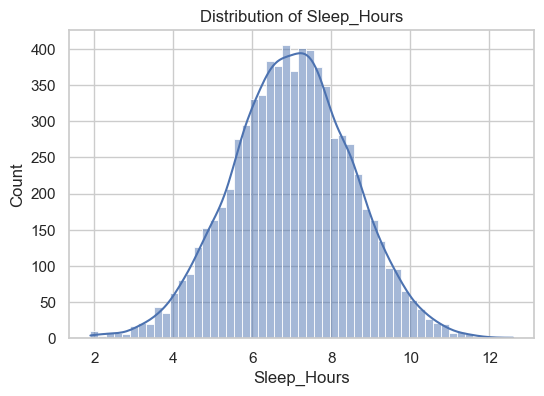

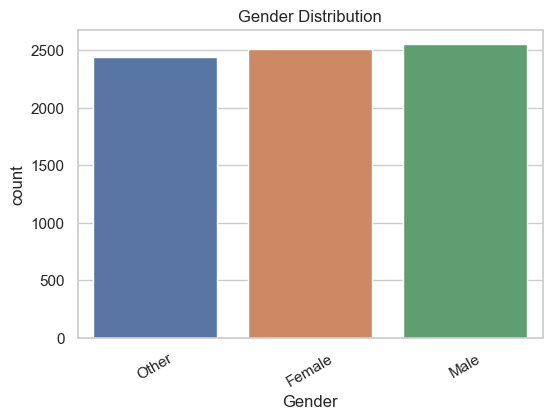

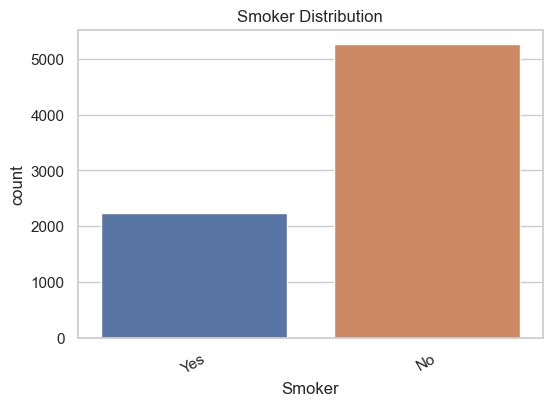

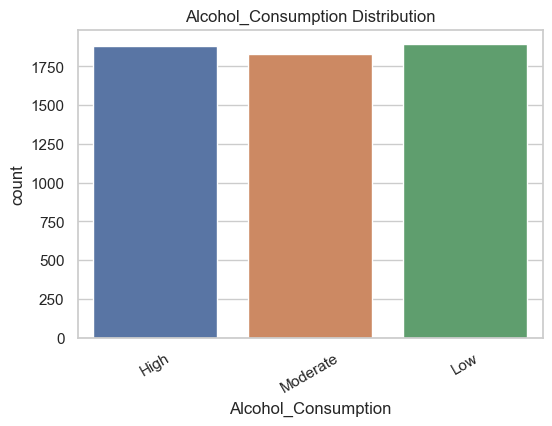

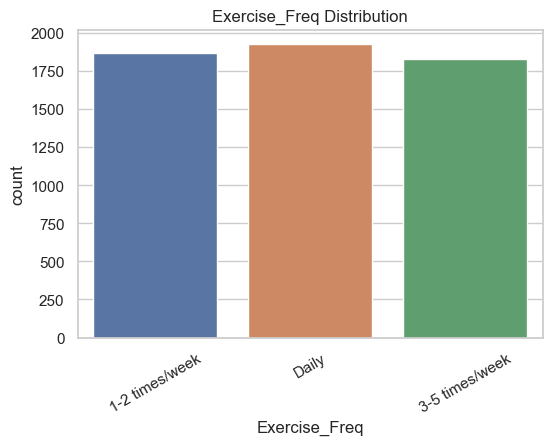

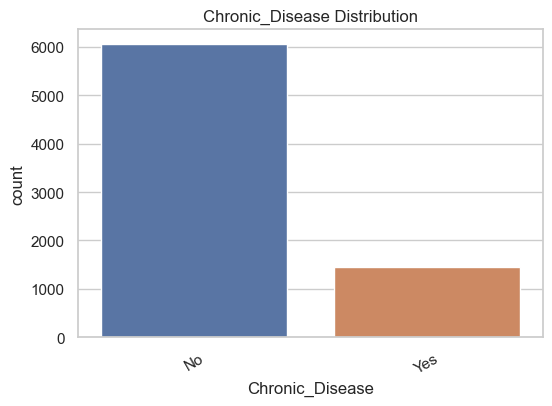

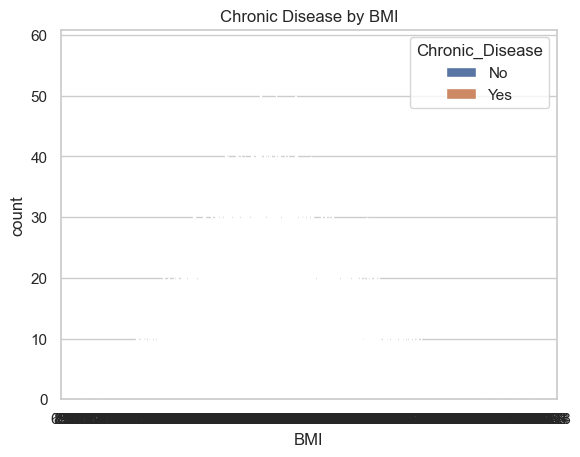

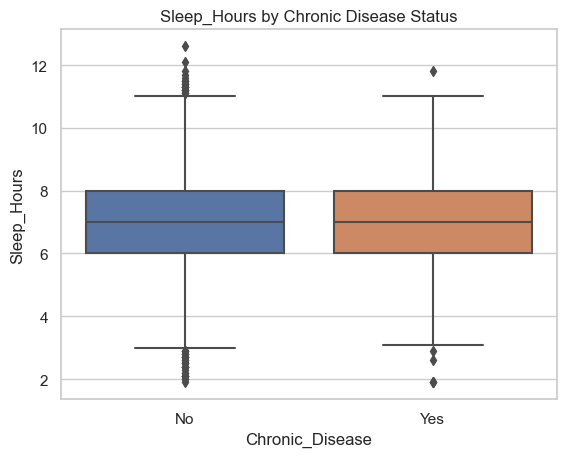

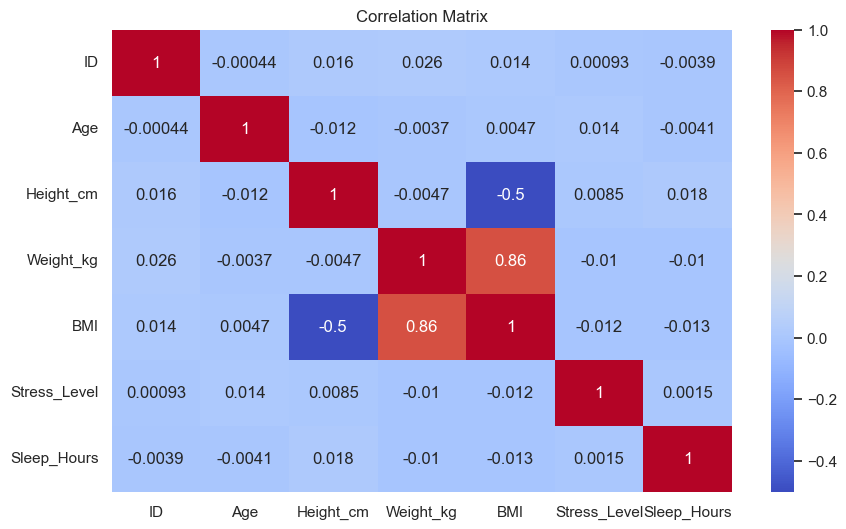

In [45]:
# This is EDA on a synthetic Health and Lifestyle dataset of 7500 individuals.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid")

# Dataset is loaded
df = pd.read_csv("/Users/sundayomotoye/Downloads/synthetic_health_lifestyle_dataset.csv")
df.head()

# To check the Dataset
print("Shape:", df.shape)
df.info()
df.describe()

# Checking for missing values.
df.isnull().sum()

# This is the Distribution plots
numeric_columns = ['Age', 'Height_cm', 'Weight_kg', 'BMI', 'Sleep_Hours']
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# This is the Categorical counts
for col in ['Gender', 'Smoker', 'Alcohol_Consumption', 'Exercise_Freq', 'Chronic_Disease']:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=30)
    plt.show()

# The plot of Chronic disease by category
sns.countplot(data=df, x='BMI', hue='Chronic_Disease')
plt.title('Chronic Disease by BMI')
plt.show()

sns.boxplot(data=df, x='Chronic_Disease', y='Sleep_Hours')
plt.title('Sleep_Hours by Chronic Disease Status')
plt.show()

# This is heatmap correlation.
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [57]:
# Modeling (Classification Task – Predict Chronic Disease)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
# Feature engineering: BMI category
def BMI_category(BMI):
    if BMI < 18.5: return 'Underweight'
    elif BMI < 25: return 'Normal'
    elif BMI < 30: return 'Overweight'
    else: return 'Obese'

df['BMI_category'] = df['BMI'].apply(BMI_category)

In [61]:
# Lifestyle score (simple model)
df['lifestyle_score'] = (
    df['Smoker'].map({'Yes': 1, 'No': 0}) +
    df['Alcohol_Consumption'].map({'Yes': 1, 'No': 0}) +
    df['Exercise_Freq'].map({'None': 2, 'Low': 1, 'Moderate': 0, 'High': 0})
)


In [63]:
# Encode labels
df_model = df.copy()
label_cols = ['Gender', 'Smoker', 'Alcohol_Consumption', 'Exercise_Freq', 'BMI_category', 'Chronic_Disease']
le = LabelEncoder()
for col in label_cols:
    df_model[col] = le.fit_transform(df_model[col])

In [69]:
# Features and target
X = df_model[['Age', 'BMI', 'Sleep_Hours', 'Gender', 'Smoker', 'Alcohol_Consumption', 'Exercise_Freq']]
y = df_model['Chronic_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Model training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [73]:
# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1185   14]
 [ 295    6]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      1199
           1       0.30      0.02      0.04       301

    accuracy                           0.79      1500
   macro avg       0.55      0.50      0.46      1500
weighted avg       0.70      0.79      0.71      1500



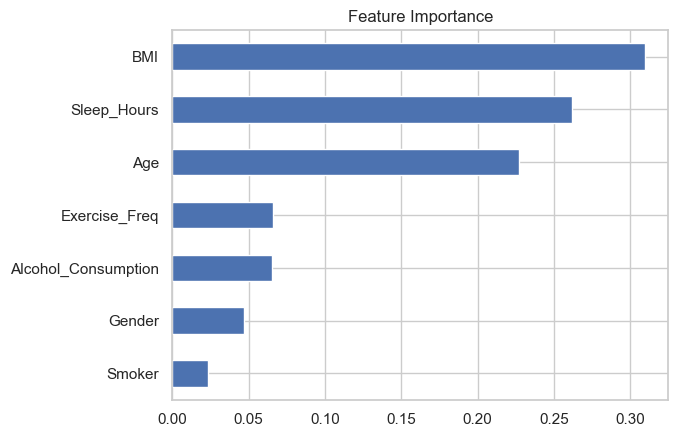

In [75]:
# Feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

In [79]:
# Generate health recommendations
def generate_advice(row):
    advice = []
    if row['Smoker'] == 'Yes': advice.append("Stop smoking.")
    if row['Alcohol_Consumption'] == 'Yes': advice.append("Limit alcohol.")
    if row['Exercise_Freq'] in ['None', 'Low']: advice.append("Exercise more.")
    if row['Sleep_Hours'] < 6: advice.append("Increase sleep duration.")
    if row['BMI_category'] in ['Overweight', 'Obese']: advice.append("Consult for weight control.")
    return " ".join(advice)

df['health_advice'] = df.apply(generate_advice, axis=1)

In [81]:
# Export for dashboard use
df.to_csv("health_lifestyle_with_recommendations.csv", index=False)
df[['Age', 'Gender', 'BMI_category', 'Chronic_Disease', 'health_advice']].head(10)

,Age,Gender,BMI_category,Chronic_Disease,health_advice
0,56,Other,Underweight,No,Stop smoking.
1,69,Other,Normal,No,Increase sleep duration.
2,46,Female,Overweight,No,Increase sleep duration. Consult for weight co...
3,32,Male,Overweight,No,Consult for weight control.
4,60,Male,Normal,Yes,
5,25,Female,Normal,No,Increase sleep duration.
6,38,Other,Obese,Yes,Increase sleep duration. Consult for weight co...
7,56,Male,Normal,No,
8,36,Male,Underweight,No,
9,40,Other,Overweight,Yes,Stop smoking. Increase sleep duration. Consult...
